# Exploratory Data Analysis

This notebook provides a dataset and code templates to use in the exploration of a dataset.

The dataset is from the US Census Bureau, Surevey of Construction (SOC) Microdata files for the years 2012 through 2018.

To save time and hassle, the files for the individual years have been concatenated together and made available as a pandas pickled dataframe.  One of the dimensions is the US Census region, so we'll be doing some regional cuts and maps.


## Useful Links
[Characteristics of New Housing](https://www.census.gov/construction/chars/)

SOC = Survey of Construction.

Microdata = Sample of records published for each year. 24211 records for 2018

[Microdata Page](https://www.census.gov/construction/chars/microdata.html)

[Using the SOC Microdata](https://www.census.gov/construction/chars/pdf/using_socmicro.pdf) describes pivot table construction from the micro data file.

[Field Definitions](https://www.census.gov/construction/chars/pdf/socmicro_info.pdf) Helpful to have this link open when working with this dataset


In [46]:
#need geopandas
!pip install geopandas

In [0]:
#whole buncha imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.patches as mpatches

%matplotlib inline

In [0]:
from urllib.request import urlopen

## Load the dataset

In [0]:
lnk= 'https://focods.s3.us-east-2.amazonaws.com/soc_df.pkl.bz2'
with urlopen(lnk) as pkl:
  soc_df2 = pd.read_pickle(pkl, compression='bz2')

In [5]:
soc_df2.columns

Index(['ACS', 'AGER', 'AREA', 'AREA_F', 'ASSOC', 'AUTH', 'BASE', 'BEDR', 'CAT',
       'CLOS', 'COMP', 'CON', 'CONPR', 'CONPR_F', 'DECK', 'DET', 'DIV',
       'FCONPR', 'FCONPR_F', 'FFNSQ', 'FFNSQ_F', 'FINC', 'FNBS', 'FNSQ',
       'FNSQ_F', 'FOYER', 'FPLS', 'FRAME', 'FSLPR', 'FSLPR_F', 'FSQFS',
       'FSQFS_F', 'FUEL', 'FUEL2', 'FULB', 'GAR', 'HAFB', 'HEAT', 'HEAT2',
       'ID', 'LNDR', 'LOTV', 'LOTV_F', 'METRO', 'MFGS', 'PATI', 'PRCH',
       'PVALU', 'PVALU_F', 'SALE', 'SEWER', 'SLPR', 'SLPR_F', 'SQFS', 'SQFS_F',
       'STOR', 'STRT', 'WAL1', 'WAL2', 'WALS', 'WATER', 'WEIGHT', 'YEAR',
       'DIVNAME'],
      dtype='object')

## A Look at the Census Regions

### Get the Shapefile

In [0]:
#back up path
#shape_file_path='https://focods.s3.us-east-2.amazonaws.com/cb_2018_us_division_500k.zip'

#get the shape file directly from the source (US Census Bureau)
shape_file_path='https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_division_500k.zip'
gdf = gpd.read_file(shape_file_path)

#GEOID comes in as string, handier if an int
gdf.GEOID  = [int(g) for g in gdf.GEOID]
gdf.set_index('GEOID', inplace=True) #now we can index by GEOID

### Plot the Census Regions

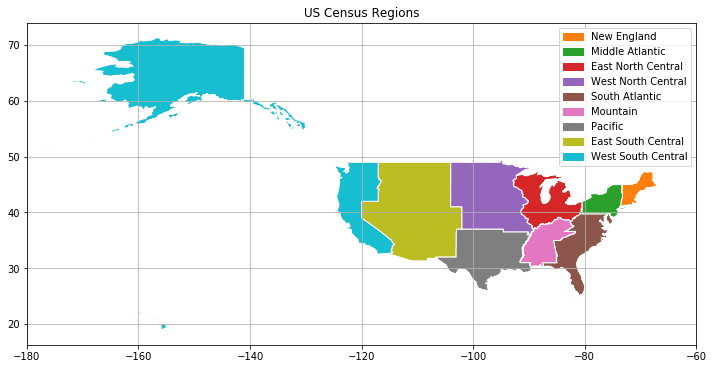

In [7]:
color_list = plt.cm.tab10(np.linspace(0, 1, 10))
colors = color_list[gdf.index]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

gdf.plot(ax=ax, color=colors, edgecolor='white')
label_handles = [mpatches.Patch(color=colors[gid-1], label=gdf.loc[gid].NAME) for gid in gdf.index]

ax.set_xlim(-180,-60) # don't need to see the whole world
ax.legend(handles=label_handles)
ax.grid()
_=ax.set_title('US Census Regions')

## Tools for Dealing with Weighted Data

In [0]:
def expand_weighted_obs(obs, weights):
  """
  returns a vector of observations, expanding the input obs by the counts contained in weights
  obs and weights parameters can be pandas series
  """
  obs_list = np.repeat(obs, weights)

  return obs_list


In [0]:
def expand_all(n, y, g, col):
  """
  returns a dataframe by expanding input dataframe's column 'col' by g's WEIGHT column
  Tacks on division name (parameter n) and year (parameter y) on each row
  """
  return pd.DataFrame({'DIVNAME':n,
                       'YEAR':y,
                       col: expand_weighted_obs(g[col], g.WEIGHT)})

## Total Houses by Region by Year

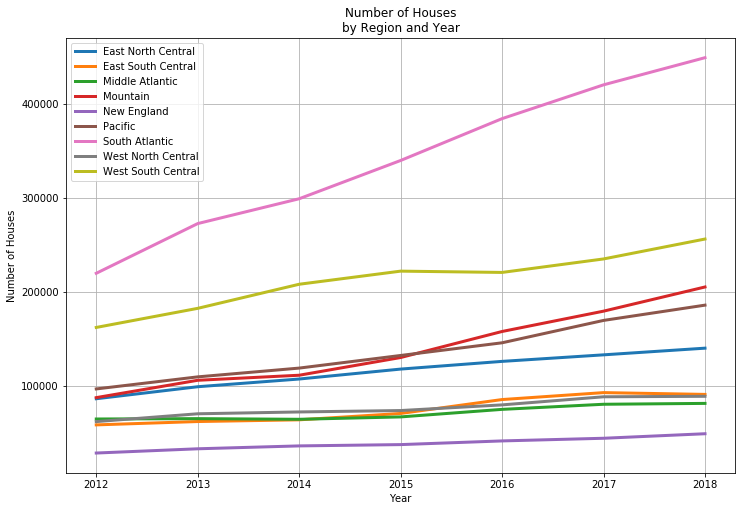

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

div_tot = soc_df2[['YEAR','DIVNAME','WEIGHT']].groupby(['DIVNAME','YEAR']).sum().reset_index()
for div, dt in div_tot.groupby('DIVNAME'):
  ax.plot(dt.YEAR, dt.WEIGHT, label=div, linewidth=3)

ax.grid()
ax.set_xlabel('Year')
ax.set_ylabel('Number of Houses')
ax.set_title('Number of Houses\nby Region and Year')
ax.legend()

## Sales Price Mountain Region

In [0]:
#SLPR is sales price
# exclude the rows on which the sales price is not reported (i.e. == 0)
mountain_sales_2018 = soc_df2.query('YEAR==2018 and DIVNAME==\'Mountain\' and SLPR != 0.0')

In [12]:
len(mountain_sales_2018)

1691

In [0]:
mountain_slpr = expand_weighted_obs(mountain_sales_2018.SLPR, mountain_sales_2018.WEIGHT)

In [14]:
#length of the expanded observations should equal the sum of the weights
len(mountain_slpr), mountain_sales_2018.WEIGHT.sum()

(132714, 132714)

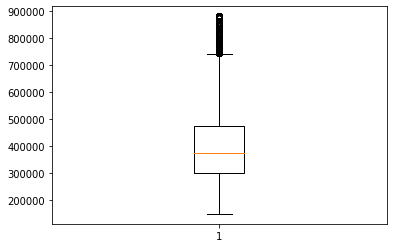

In [15]:
#simple box plot to see what it looks like
_=plt.boxplot(mountain_slpr)

## 2018 Sales Price Across All Regions

In [0]:
# data frame with non-zero SLPR for 2018 and all regions:
slpr_2018 = soc_df2.query('YEAR==2018 and SLPR != 0.0')[['DIVNAME','SLPR','WEIGHT']]

In [0]:
# want to look at SLPR by Division
slpr_2018_grouped = slpr_2018.groupby('DIVNAME')

In [0]:
#expand each group, concatenating the expansions into one dataframe
slpr_2018_exp = pd.concat([expand_all(n,2018,g, 'SLPR') for n,g in slpr_2018_grouped])

In [19]:
len(slpr_2018), slpr_2018.WEIGHT.sum(), len(slpr_2018_exp)

(12577, 829226, 829226)

Text(0.5, 0, 'Region')

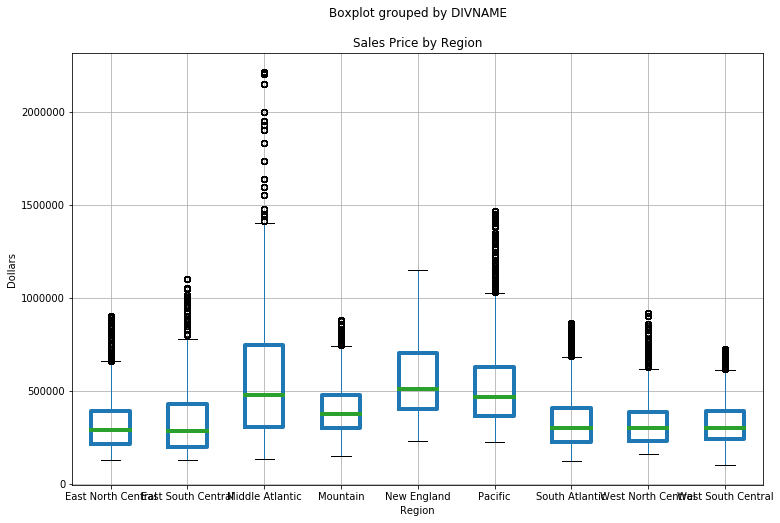

In [20]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
slpr_2018_exp.boxplot('SLPR',ax=ax, by='DIVNAME',
                      boxprops=dict(linestyle='-', linewidth=4, color='red'),
                      medianprops = dict(linestyle='-', linewidth=4, color='red'))
ax.set_title('Sales Price by Region')
ax.set_ylabel('Dollars')
ax.set_xlabel('Region')

## 2018 Median Sales Price Choropleth

In [0]:
# get the median price for each division
median_by_div = slpr_2018_exp.groupby('DIVNAME').agg(np.median)

In [0]:
# tack the median price onto each row of the shapefile data frame
gdf_median = pd.merge(gdf, median_by_div, left_on='NAME', right_on='DIVNAME')

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

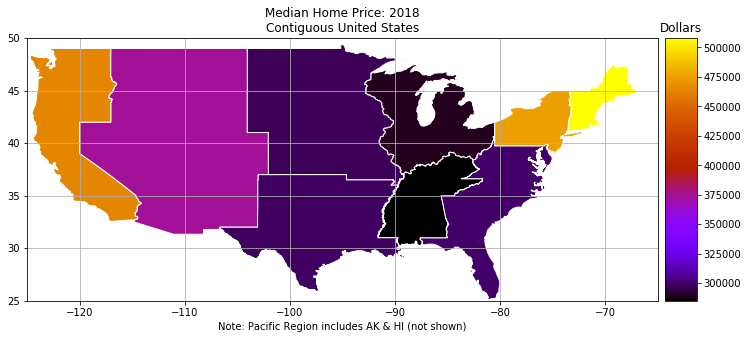

In [24]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, title='Dollars')
gdf_median.plot('SLPR', legend=True, ax=ax, cax=cax, edgecolor='white', cmap='gnuplot')

ax.set_title('Median Home Price: 2018\nContiguous United States')

#wire down for just contiguous states
ax.set_xlim(-125,-65)
ax.set_ylim(25,50)
ax.set_xlabel('Note: Pacific Region includes AK & HI (not shown)')

ax.grid()


## Median Sales Price over Time

### Data Reduction

In [0]:
#need the non-zero SLPR records, their weights and the YEAR and Division name
slpr_nonzero = soc_df2.query('SLPR != 0.0')[['YEAR','DIVNAME','SLPR','WEIGHT']]

In [0]:
slpr_exp = pd.concat([expand_all(n[0],n[1],g, 'SLPR') for n,g in slpr_nonzero.groupby(['DIVNAME','YEAR'])])

In [27]:
#the sum of the weights should equal the number of rows in the expanded obs dataframe
len(slpr_nonzero), slpr_nonzero.WEIGHT.sum(), len(slpr_exp)

(77802, 4443751, 4443751)

In [28]:
# here's what we're dealing with
slpr_exp.head()

,DIVNAME,YEAR,SLPR
2090,East North Central,2012,325000
2090,East North Central,2012,325000
2090,East North Central,2012,325000
2090,East North Central,2012,325000
2090,East North Central,2012,325000


In [0]:
#apply the np.median function to each division, year group
slpr_med = slpr_exp.groupby(['DIVNAME','YEAR']).agg(np.median)

In [30]:
#the result
slpr_med

SLPR
DIVNAME            YEAR        
East North Central 2012  240000
                   2013  261900
                   2014  290200
                   2015  285000
                   2016  283000
...                         ...
West South Central 2014  250000
                   2015  279000
                   2016  296900
                   2017  307000
                   2018  299000

[63 rows x 1 columns]

### The Plot

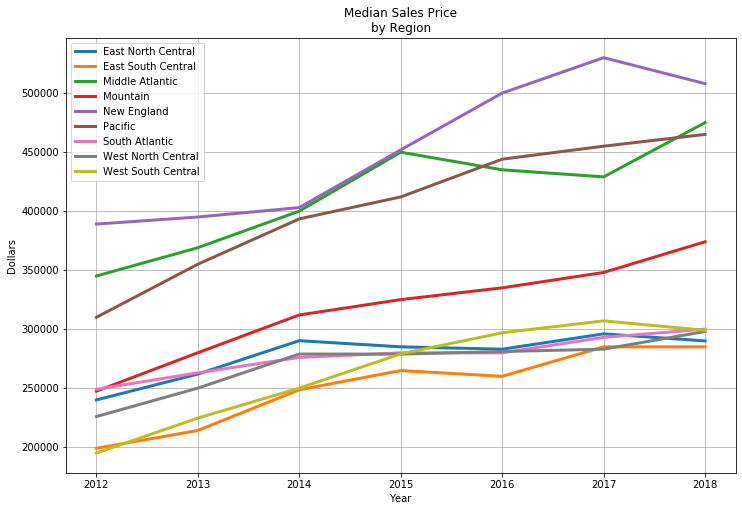

In [31]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

# loop through regions, plot each one
regions = slpr_med.index.get_level_values('DIVNAME').unique() #list of regions
for reg in regions:
  #slpr_med.loc[reg].index is the YEAR portion of the index
  years = slpr_med.loc[reg].index
  median_slpr = slpr_med.loc[reg]['SLPR'] #the median prices
  ax.plot(years, median_slpr, label=reg, linewidth=3)

ax.grid()
ax.set_xlabel('Year')
ax.set_ylabel('Dollars')
ax.set_title('Median Sales Price\nby Region')
ax.legend()

## Square Footage

Weighted average of square footage.  Column name is SQFS

In [0]:
#need the non-zero SQFS records, their weights and the YEAR and Division name
sqfs_nonzero = soc_df2.query('SQFS != 0.0')[['YEAR','DIVNAME','SQFS','WEIGHT']]

In [0]:
sqfs_exp = pd.concat([expand_all(n[0],n[1],g, 'SQFS') for n,g in sqfs_nonzero.groupby(['DIVNAME','YEAR'])])

In [34]:
len(sqfs_nonzero), sqfs_nonzero.WEIGHT.sum(), len(sqfs_exp)

(142786, 8014084, 8014084)

In [0]:
#apply the np.mean function to each division, year group
sqfs_mean = sqfs_exp.groupby(['DIVNAME','YEAR']).mean()

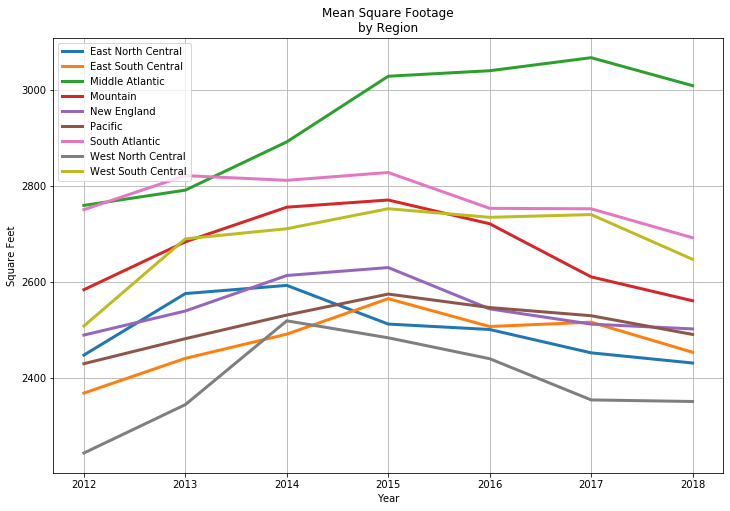

In [36]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

# loop through regions, plot each one
regions = sqfs_mean.index.get_level_values('DIVNAME').unique() #list of regions
for reg in regions:
  #slpr_med.loc[reg].index is the YEAR portion of the index
  years = sqfs_mean.loc[reg].index
  mean_sqfs = sqfs_mean.loc[reg]['SQFS'] #the mean square footage
  ax.plot(years, mean_sqfs, label=reg, linewidth=3)

ax.grid()
ax.set_xlabel('Year')
ax.set_ylabel('Square Feet')
ax.set_title('Mean Square Footage\nby Region')
ax.legend()

### Scatter Plot Price versus Square Footage

In [0]:
sqfs_ma = soc_df2.query('SQFS != 0.0 and SLPR != 0 and DIVNAME==\'Middle Atlantic\'')[['YEAR','DIVNAME','SQFS', 'SLPR','WEIGHT']]
sqfs_ma_exp = pd.concat([expand_all(n[0],n[1],g, 'SQFS') for n,g in sqfs_ma.groupby(['DIVNAME','YEAR'])])
slpr_ma_exp = pd.concat([expand_all(n[0],n[1],g, 'SLPR') for n,g in sqfs_ma.groupby(['DIVNAME','YEAR'])])

In [38]:
sqfs_ma_exp.head()

,DIVNAME,YEAR,SQFS
680,Middle Atlantic,2012,2430
680,Middle Atlantic,2012,2430
680,Middle Atlantic,2012,2430
680,Middle Atlantic,2012,2430
680,Middle Atlantic,2012,2430


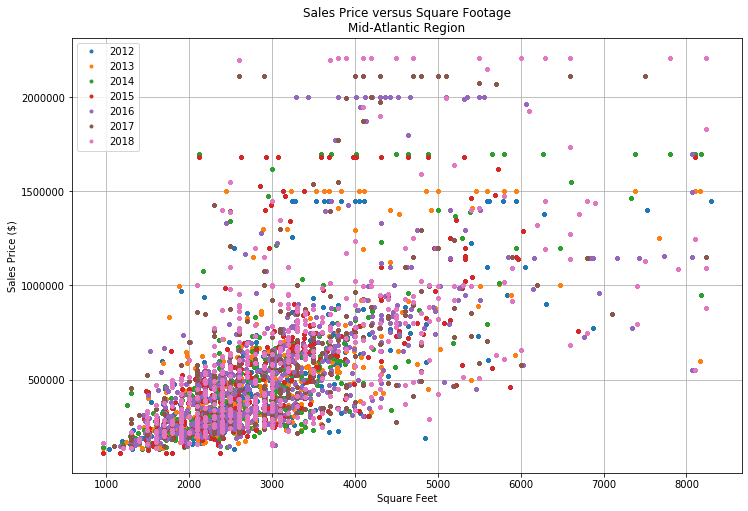

In [39]:


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
years = range(2012, 2019)
for yr in years:
  sqft = sqfs_ma_exp.query('YEAR==@yr').SQFS
  slpr = slpr_ma_exp.query('YEAR==@yr').SLPR
  ax.plot(sqft, slpr, '.', label=str(yr))

ax.grid()
ax.set_xlabel('Square Feet')
ax.set_ylabel('Sales Price ($)')
ax.set_title('Sales Price versus Square Footage\nMid-Atlantic Region')
ax.legend()

## Number of Bedrooms

In [0]:
mtn_2018 = soc_df2.query('DIVNAME == \'Mountain\' and YEAR == 2018')

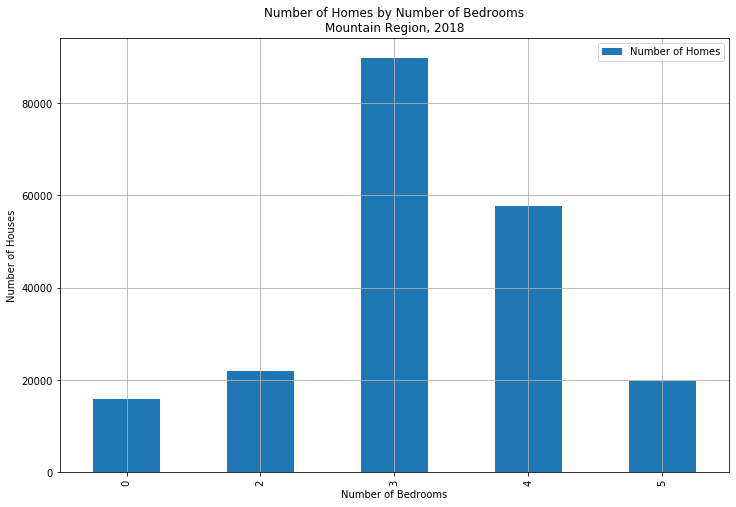

In [41]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

mtn_2018.groupby('BEDR').sum().WEIGHT.plot.bar( ax=ax, label='Number of Homes')

ax.grid()
ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Number of Houses')
ax.set_title('Number of Homes by Number of Bedrooms\nMountain Region, 2018')
ax.legend()

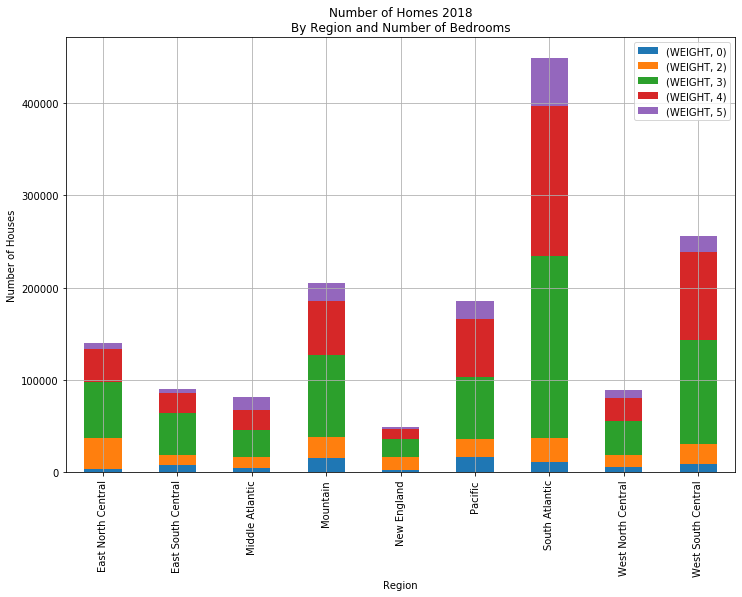

In [45]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

soc_df2.query('YEAR==2018')[['DIVNAME','BEDR','WEIGHT']]\
      .groupby(['DIVNAME','BEDR']).sum().unstack()\
      .plot.bar( ax=ax, stacked=True, label='#Houses')

ax.grid()
ax.set_xlabel('Region')
ax.set_ylabel('Number of Houses')
ax.set_title('Number of Homes 2018\nBy Region and Number of Bedrooms')
ax.legend()
